In [1]:
%load_ext tensorboard

# UNet - Take 1

Epoch 1/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.0104]


Validation Loss: 0.021285814617529212


Epoch 2/10: 100%|██████████| 1190/1190 [07:42<00:00,  2.57it/s, loss=0.0115] 


Validation Loss: 0.016791173413195866


Epoch 3/10: 100%|██████████| 1190/1190 [07:42<00:00,  2.57it/s, loss=0.00716]


Validation Loss: 0.01421524001122921


Epoch 4/10: 100%|██████████| 1190/1190 [07:42<00:00,  2.57it/s, loss=0.00963]


Validation Loss: 0.013852547297891754


Epoch 5/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.0109] 


Validation Loss: 0.013076518710715159


Epoch 6/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.0171] 


Validation Loss: 0.012188561924814477


Epoch 7/10: 100%|██████████| 1190/1190 [07:45<00:00,  2.56it/s, loss=0.0175] 


Validation Loss: 0.01179067963256107


Epoch 8/10: 100%|██████████| 1190/1190 [07:45<00:00,  2.56it/s, loss=0.00835]


Validation Loss: 0.011539092159286241


Epoch 9/10: 100%|██████████| 1190/1190 [07:45<00:00,  2.56it/s, loss=0.00966]


Validation Loss: 0.011733282691074048


Epoch 10/10: 100%|██████████| 1190/1190 [07:44<00:00,  2.56it/s, loss=0.00617]


Validation Loss: 0.010705978507269799


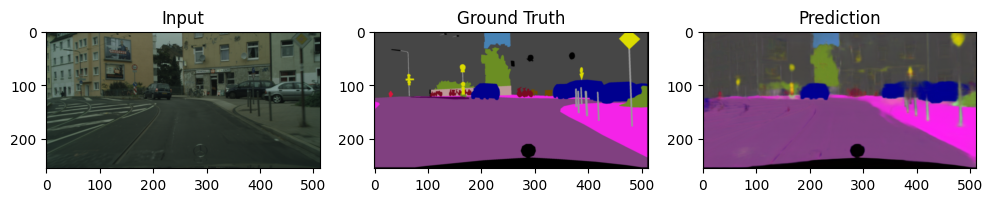

In [118]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# U-Net model definition (same as before)
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        def CBR(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, 3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
        
        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        
        self.middle = CBR(512, 1024)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, 3, kernel_size=1)
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        m = self.middle(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(m), e4], 1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], 1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], 1))
        return self.final(d1)

# Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, image_root, mask_root, transform=None):
        self.image_paths = []
        self.mask_paths = []
        self.transform = transform

        for root, _, files in os.walk(image_root):
            for file in files:
                if file.endswith("_leftImg8bit.png"):
                    image_path = os.path.join(root, file)
                    city = os.path.basename(root)
                    mask_file = file.replace("_leftImg8bit.png", "_gtFine_color.png")
                    mask_path = os.path.join(mask_root, city, mask_file)
                    if os.path.exists(mask_path):
                        self.image_paths.append(image_path)
                        self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transforms
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
])

# Dataset paths
image_dir = '/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/train'
mask_dir = '/kaggle/input/gtfine-trainvaltest/gtFine/train'

# Create datasets and loaders
dataset = SegmentationDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=2, shuffle=False)

# Training function
def train_model(model, train_loader, val_loader, device, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, masks).item()
            print(f"Validation Loss: {val_loss / len(val_loader)}")

# Train model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
train_model(model, train_loader, val_loader, device, num_epochs=10)

# Sample prediction view
def show_sample(model, dataset, device):
    model.eval()
    image, mask = dataset[0]
    with torch.no_grad():
        pred = model(image.unsqueeze(0).to(device)).squeeze(0).cpu()
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image.permute(1, 2, 0))
    axs[0].set_title("Input")
    axs[1].imshow(mask.permute(1, 2, 0))
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred.permute(1, 2, 0))
    axs[2].set_title("Prediction")
    plt.show()

# Display prediction
show_sample(model, dataset, device)


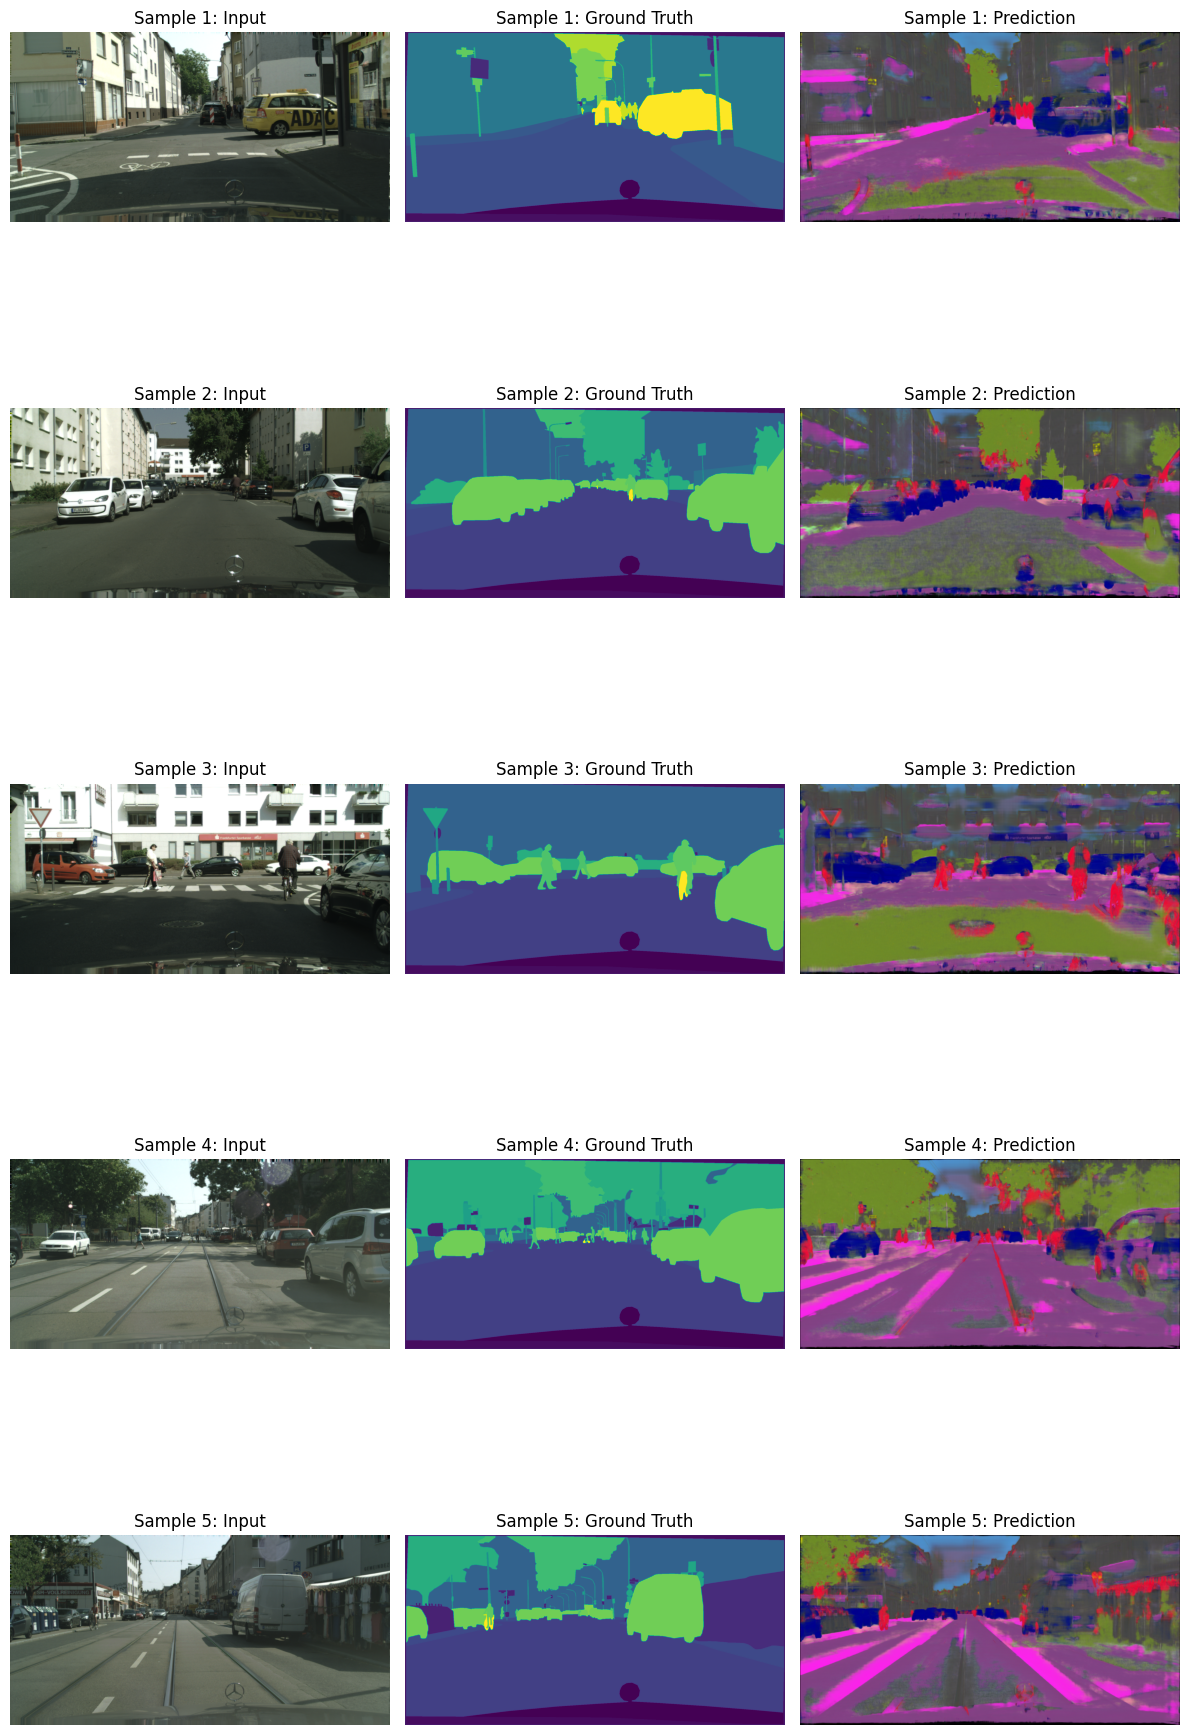

In [141]:
import matplotlib.pyplot as plt
import torch

def show_samples(model, dataset, device, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for idx in range(num_samples):
        image, mask = dataset[idx]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device)).squeeze(0).cpu()
        
        axs[idx, 0].imshow(image.permute(1, 2, 0))
        axs[idx, 0].set_title(f"Sample {idx+1}: Input")
        # axs[idx, 1].imshow(mask.permute(1, 2, 0))
        axs[idx, 1].imshow(mask)#, cmap='gray')  # for class masks

        axs[idx, 1].set_title(f"Sample {idx+1}: Ground Truth")
        axs[idx, 2].imshow(pred.permute(1, 2, 0))
        axs[idx, 2].set_title(f"Sample {idx+1}: Prediction")

        for ax in axs[idx]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

val_dataset = CityscapesDataset(
    '/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/val',
    '/kaggle/input/gtfine-trainvaltest/gtFine/val',
    transform=transform
)

show_samples(model, val_dataset, device, num_samples=5)

In [148]:
%reload_ext tensorboard

In [190]:
!cd /kaggle/working/ngrok


/bin/bash: line 1: cd: /kaggle/working/ngrok: Not a directory


In [191]:
!wget -q -nc https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xzf ngrok-v3-stable-linux-amd64.tgz

In [192]:
!./ngrok authtoken 2voN3tEHBYafIGbDKTLkFazm2Mg_6dWbAfezhiCGtQ7kQ1TpX

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
Default version saved to configuration file: /root/.ngrok2/ngrok.yml


In [209]:
!pkill tensorboard
!killall ngrok

TensorBoard caught SIGTERM; exiting...


In [210]:
import os
import multiprocessing


pool = multiprocessing.Pool(processes = 10)
results_of_processes = [pool.apply_async(os.system, args=(cmd, ), callback = None )
                        for cmd in [
                        f"tensorboard --logdir /kaggle/working/logs/segmentation/ --host 0.0.0.0 --port 6006 &",
                        "./ngrok http 6006 &"
                        ]]

2025-04-16 14:52:03.296586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744815123.319242    2124 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744815123.326377    2124 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.18.0 at http://0.0.0.0:6006/ (Press CTRL+C to quit)


In [211]:
!curl -s http://localhost:4040/api/tunnels | \
  python3 -c "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://ea53-34-80-67-200.ngrok-free.app


In [206]:
!ls -l /kaggle/working/logs 

total 1376
-rw-r--r-- 1 root root 1403601 Apr 16 06:09 events.out.tfevents.1744781803.3b1089f31d57.31.1
drwxr-xr-x 2 root root    4096 Apr 16 12:37 segmentation


In [197]:
# # !netstat -aonp|grep ensor
# !sudo ss -lptn 'sport = :8888'

State     Recv-Q    Send-Q       Local Address:Port        Peer Address:Port    Process                                                                         
LISTEN    0         128                0.0.0.0:8888             0.0.0.0:*        users:(("jupyter-noteboo",pid=1,fd=7))                                         
LISTEN    0         128                   [::]:8888                [::]:*        users:(("jupyter-noteboo",pid=1,fd=8))                                         


# UNet : Take 2

In [207]:
# Preparing a modified version of the provided code to include TensorBoard logging for metrics.

from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import numpy as np

# Helper functions for segmentation metrics
def compute_iou(pred, target, num_classes=3):
    iou_list = []
    pred = pred.argmax(dim=1)
    target = target.argmax(dim=1)

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            iou_list.append(float('nan'))
        else:
            iou_list.append(intersection / union)
    return np.nanmean(iou_list), iou_list

def compute_dice(pred, target, num_classes=3):
    dice_list = []
    pred = pred.argmax(dim=1)
    target = target.argmax(dim=1)

    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds & target_inds).sum().item()
        total = pred_inds.sum().item() + target_inds.sum().item()
        if total == 0:
            dice_list.append(float('nan'))
        else:
            dice_list.append((2. * intersection) / total)
    return np.nanmean(dice_list), dice_list

def compute_pixel_accuracy(pred, target):
    pred = pred.argmax(dim=1)
    target = target.argmax(dim=1)
    correct = (pred == target).sum().item()
    total = target.numel()
    return correct / total

# Updated training function with TensorBoard logging
def train_model_with_tensorboard(model, train_loader, val_loader, device, log_dir="logs/segmentation", num_epochs=10):
    writer = SummaryWriter(log_dir=log_dir)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for imgs, masks in loop:
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)

        # Evaluation
        model.eval()
        val_loss = 0.0
        all_preds, all_targets = [], []

        with torch.no_grad():
            for imgs, masks in val_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, masks).item()
                all_preds.append(outputs)
                all_targets.append(masks)

        avg_val_loss = val_loss / len(val_loader)
        writer.add_scalar("Loss/Validation", avg_val_loss, epoch)

        preds = torch.cat(all_preds)
        targets = torch.cat(all_targets)

        mean_iou, _ = compute_iou(preds, targets)
        mean_dice, _ = compute_dice(preds, targets)
        pixel_acc = compute_pixel_accuracy(preds, targets)

        writer.add_scalar("Metrics/IoU", mean_iou, epoch)
        writer.add_scalar("Metrics/Dice", mean_dice, epoch)
        writer.add_scalar("Metrics/Pixel_Accuracy", pixel_acc, epoch)

        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | IoU: {mean_iou:.4f} | Dice: {mean_dice:.4f} | Pixel Acc: {pixel_acc:.4f}")

    writer.close()

# The user should call:
# %load_ext tensorboard
# %tensorboard --logdir logs/segmentation

# And then run:
# train_model_with_tensorboard(model, train_loader, val_loader, device, num_epochs=10)



In [208]:
%load_ext tensorboard
%tensorboard --logdir logs/segmentation

train_model_with_tensorboard(model, train_loader, val_loader, device, num_epochs=10)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

Epoch 1/10: 100%|██████████| 1190/1190 [07:50<00:00,  2.53it/s, loss=0.00604]


Epoch 1 | Val Loss: 0.0105 | IoU: 0.3725 | Dice: 0.5395 | Pixel Acc: 0.5499


Epoch 2/10: 100%|██████████| 1190/1190 [07:44<00:00,  2.56it/s, loss=0.00582]


Epoch 2 | Val Loss: 0.0107 | IoU: 0.5339 | Dice: 0.6933 | Pixel Acc: 0.7253


Epoch 3/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.013]  


Epoch 3 | Val Loss: 0.0106 | IoU: 0.4529 | Dice: 0.6160 | Pixel Acc: 0.6353


Epoch 4/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.00769]


Epoch 4 | Val Loss: 0.0101 | IoU: 0.4990 | Dice: 0.6571 | Pixel Acc: 0.6875


Epoch 5/10: 100%|██████████| 1190/1190 [07:44<00:00,  2.56it/s, loss=0.00922]


Epoch 5 | Val Loss: 0.0101 | IoU: 0.4306 | Dice: 0.5937 | Pixel Acc: 0.6072


Epoch 6/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.00732]


Epoch 6 | Val Loss: 0.0111 | IoU: 0.3834 | Dice: 0.5372 | Pixel Acc: 0.5161


Epoch 7/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.019]  


Epoch 7 | Val Loss: 0.0104 | IoU: 0.4162 | Dice: 0.5839 | Pixel Acc: 0.6020


Epoch 8/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.00654]


Epoch 8 | Val Loss: 0.0098 | IoU: 0.4273 | Dice: 0.5850 | Pixel Acc: 0.5859


Epoch 9/10: 100%|██████████| 1190/1190 [07:42<00:00,  2.58it/s, loss=0.00754]


Epoch 9 | Val Loss: 0.0098 | IoU: 0.4395 | Dice: 0.6067 | Pixel Acc: 0.6304


Epoch 10/10: 100%|██████████| 1190/1190 [07:43<00:00,  2.57it/s, loss=0.00612]


Epoch 10 | Val Loss: 0.0096 | IoU: 0.3312 | Dice: 0.4759 | Pixel Acc: 0.4382


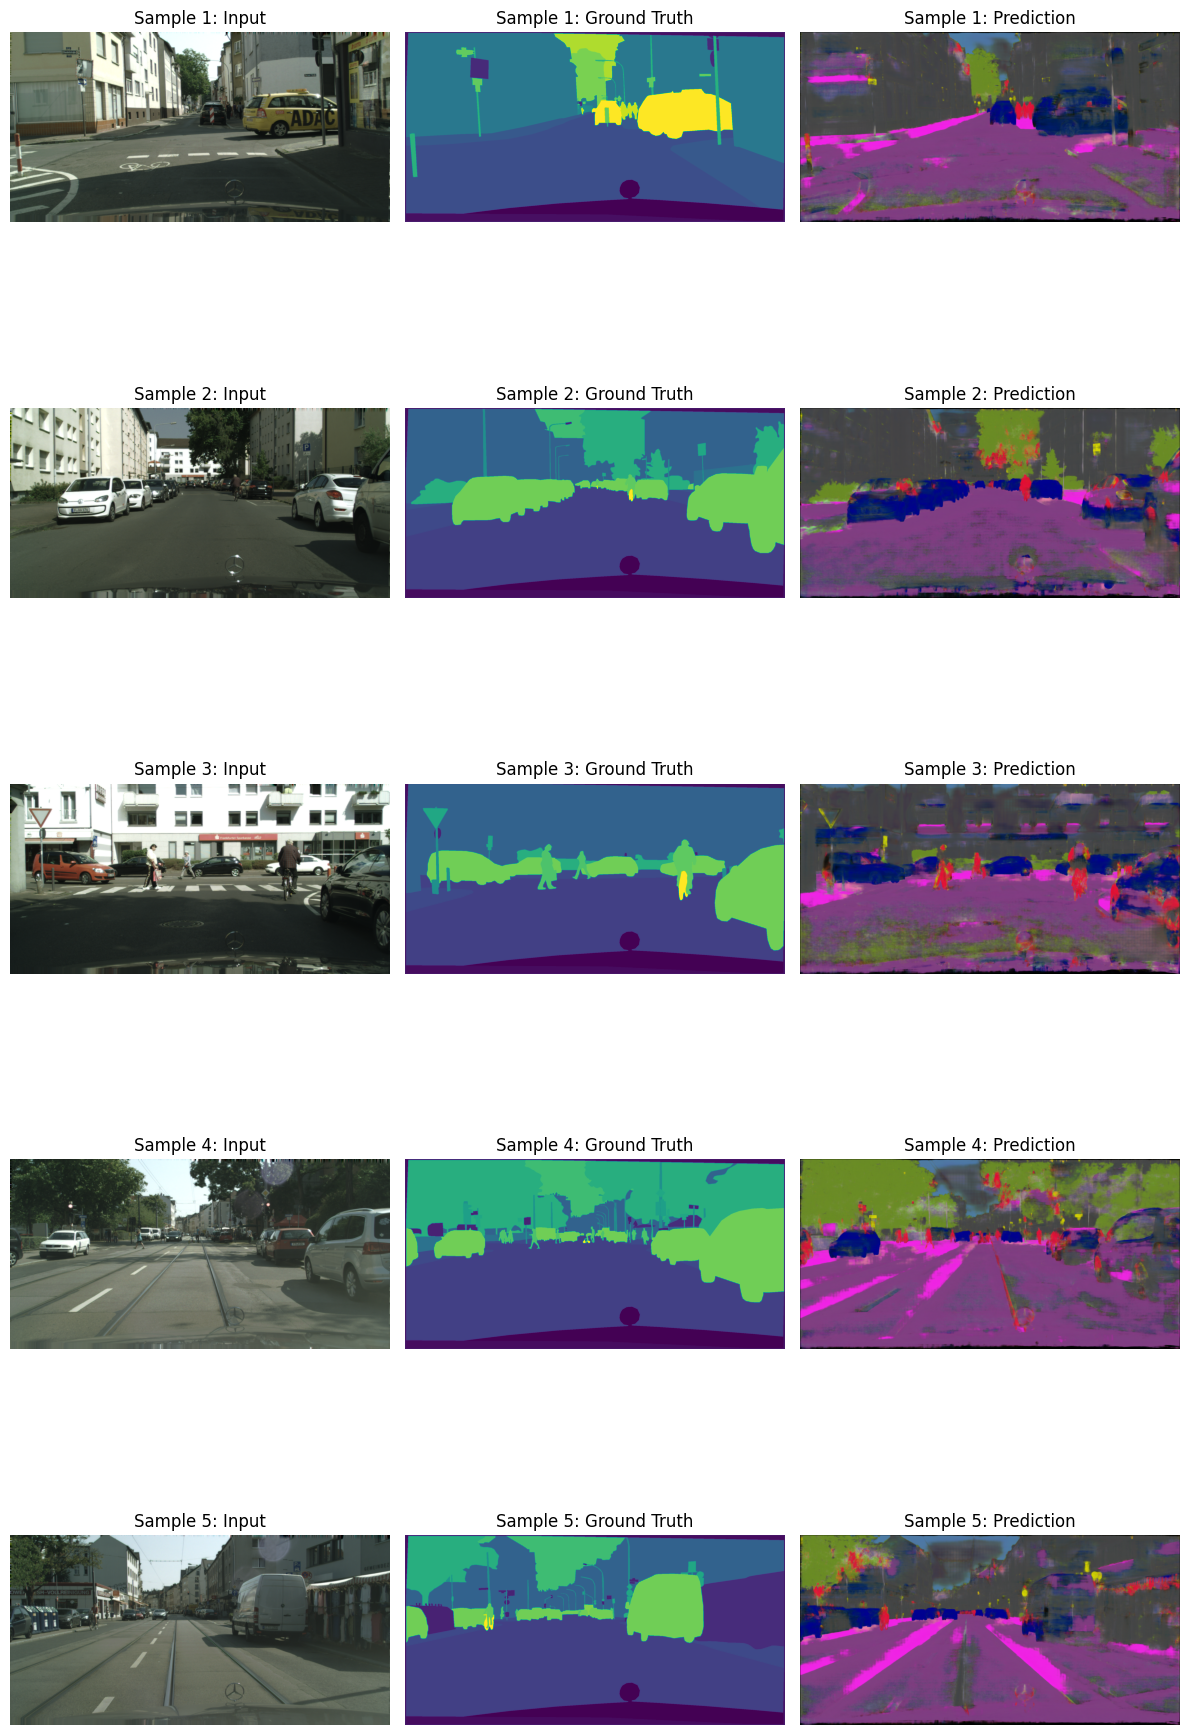

In [212]:
import matplotlib.pyplot as plt
import torch

def show_samples(model, dataset, device, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))
    
    for idx in range(num_samples):
        image, mask = dataset[idx]
        with torch.no_grad():
            pred = model(image.unsqueeze(0).to(device)).squeeze(0).cpu()
        
        axs[idx, 0].imshow(image.permute(1, 2, 0))
        axs[idx, 0].set_title(f"Sample {idx+1}: Input")
        # axs[idx, 1].imshow(mask.permute(1, 2, 0))
        axs[idx, 1].imshow(mask)#, cmap='gray')  # for class masks

        axs[idx, 1].set_title(f"Sample {idx+1}: Ground Truth")
        axs[idx, 2].imshow(pred.permute(1, 2, 0))
        axs[idx, 2].set_title(f"Sample {idx+1}: Prediction")

        for ax in axs[idx]:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

val_dataset = CityscapesDataset(
    '/kaggle/input/cityscapes-leftimg8bit-trainvaltest/leftImg8bit/val',
    '/kaggle/input/gtfine-trainvaltest/gtFine/val',
    transform=transform
)

show_samples(model, val_dataset, device, num_samples=5)

In [213]:
!pip install torchinfo


In [216]:
from torchinfo import summary
# import UNet  # if in unet.py
import torch

model1 = UNet()
summary(model, input_size=(1, 3, 256, 256))


Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [1, 3, 256, 256]          --
├─Sequential: 1-1                        [1, 64, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 64, 256, 256]         1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 256, 256]         128
│    └─ReLU: 2-3                         [1, 64, 256, 256]         --
│    └─Conv2d: 2-4                       [1, 64, 256, 256]         36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 256, 256]         128
│    └─ReLU: 2-6                         [1, 64, 256, 256]         --
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─Sequential: 1-3                        [1, 128, 128, 128]        --
│    └─Conv2d: 2-7                       [1, 128, 128, 128]        73,856
│    └─BatchNorm2d: 2-8                  [1, 128, 128, 128]        256
│    └─ReLU: 2-9                         [1, 128, 128, 128]        --
│

In [218]:
!pip install torchviz

In [220]:
import torch
# from unet import UNet
from torchviz import make_dot

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
model = UNet().to(device)

# Create input on same device
x = torch.randn(1, 3, 256, 256).to(device)

# Forward pass
y = model(x)

# Visualize
dot = make_dot(y, params=dict(model.named_parameters()))
dot.render("unet_graph", format="png")  # or format="svg" for Overleaf


'unet_graph.png'